# Problem Set #5
MACS 30150, Dr. Evans  
Minghao Yang

## 1. Some income data, lognormal distribution, and GMM (7 points)
### (a)

In [1]:
# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import numpy as np
import numpy.linalg as lin
import scipy.integrate as intgr

In [2]:
# Load the data as a NumPy array
incomes_1 = np.loadtxt('data/incomes.txt')

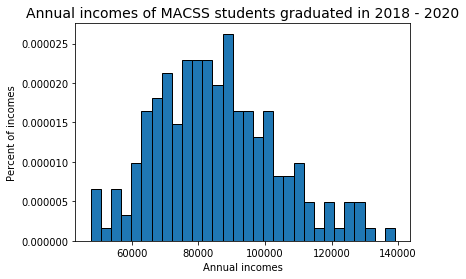

In [3]:
# Draw the histogram (normed=True is replaced by density=True to avoid warning)
num_bins = 30
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.show()

### (b)

In [4]:
# Define a function returning the mean and s.d. of the data
def data_moments_1_bc(xvals):
    
    mean_data = xvals.mean()
    sd_data = xvals.std()
    
    return mean_data, sd_data

In [5]:
# Define a function returning the mean and s.d. calculated from the model
# (To avoid the slow intgr.quad, I use formulas to calculate the mean and variance of the lognormal distribution)
def model_moments_1_bc(mu, sigma):
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    sd_model = np.sqrt((np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2))
    
    return mean_model, sd_model

In [6]:
# Define a function returning the error vector
def err_vec_1_bc(xvals, mu, sigma, simple=False):
    mean_data, sd_data = data_moments_1_bc(xvals)
    moms_data = np.array([mean_data, sd_data])
    mean_model, sd_model = model_moments_1_bc(mu, sigma)
    moms_model = np.array([mean_model, sd_model])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [7]:
# Define the criterion function
def criterion_1_bc(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec_1_bc(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [8]:
# GMM estimation and result report
mu_init_1_b = 11
sig_init_1_b = 0.5
params_init_1_b = np.array([mu_init_1_b, sig_init_1_b])
W_hat_1_b = np.eye(2)
gmm_args_1_b = (incomes_1, W_hat_1_b)
results_1_b = opt.minimize(criterion_1_bc, params_init_1_b, args=(gmm_args_1_b),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_b, sig_GMM_1_b = results_1_b.x
crit_val_GMM_1_b = results_1_b.fun
mean_data_1_bc, sd_data_1_bc = data_moments_1_bc(incomes_1)
mean_model_GMM_1_b, sd_model_GMM_1_b = model_moments_1_bc(mu_GMM_1_b, sig_GMM_1_b)
print('The GMM estimation of mu is', mu_GMM_1_b)
print('The GMM estimation of sigma is', sig_GMM_1_b)
print('The value of the criterion function at GMM estimates is', crit_val_GMM_1_b)
print('The mean of the data is', mean_data_1_bc)
print('The mean of the model is', mean_model_GMM_1_b)
print('The difference between the means is', abs(mean_data_1_bc - mean_model_GMM_1_b))
print('The percent difference between the means is', abs(mean_data_1_bc - mean_model_GMM_1_b) / mean_data_1_bc)
print('The standard deviation of the data is', sd_data_1_bc)
print('The standard deviation of the model is', sd_model_GMM_1_b)
print('The difference between the standard deviations is', abs(sd_data_1_bc - sd_model_GMM_1_b))
print('The percent difference between the standard deviations is', abs(sd_data_1_bc - sd_model_GMM_1_b) / sd_data_1_bc)

The GMM estimation of mu is 11.331880866982898
The GMM estimation of sigma is 0.20869665246828492
The value of the criterion function at GMM estimates is 1.005186460950373e-15
The mean of the data is 85276.82360625811
The mean of the model is 85276.82542230906
The difference between the means is 0.0018160509498557076
The percent difference between the means is 2.1295949744104155e-08
The standard deviation of the data is 17992.542128046523
The standard deviation of the model is 17992.541705444266
The difference between the standard deviations is 0.0004226022574584931
The percent difference between the standard deviations is 2.3487634735046507e-08


We can see that the means and standard deviations of the data and the model are similar.

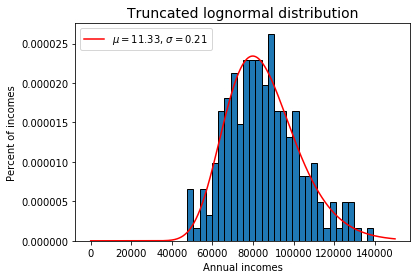

In [9]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_b, scale=np.exp(mu_GMM_1_b)),
        label='$\mu=11.33$, $\sigma=0.21$', color='r')
ax.set_title('Truncated lognormal distribution', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

### (c)

In [15]:
# Define a function returning the error matrix
# To make the error matrix and error vector consistent, I modify Dr. Evans' code so that the difference is 
# calculated by moments of model minus data instead of moments of data minus model
def get_Err_mat_1_c(pts, mu, sigma, simple=False):

    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, sd_model = model_moments_1_bc(mu, sigma)
    if simple:
        Err_mat[0, :] = mean_model - pts
        Err_mat[1, :] = sd_model - np.sqrt((mean_model - pts) ** 2)
    else:
        Err_mat[0, :] = (mean_model - pts) / pts
        Err_mat[1, :] = (sd_model - np.sqrt((mean_model - pts) ** 2)) / np.sqrt((mean_model - pts) ** 2)
    
    return Err_mat

In [16]:
# Generate the error matrix and report it
Err_mat_1_c = get_Err_mat_1_c(incomes_1, mu_GMM_1_b, sig_GMM_1_b)
VCV_1_c = (1 / incomes_1.shape[0]) * (Err_mat_1_c @ Err_mat_1_c.T)
print('The variance covariance matrix from part (b) is\n', VCV_1_c)
W_hat_1_c = lin.inv(VCV_1_c)
print('The two-step weighting matrix is\n', W_hat_1_c)

The variance covariance matrix from part (b) is
 [[5.30804094e-02 6.34972335e-03]
 [6.34972335e-03 1.32786330e+04]]
The two-step weighting matrix is
 [[ 1.88393433e+01 -9.00880519e-06]
 [-9.00880519e-06  7.53089609e-05]]


In [17]:
# Two-step GMM estimation and result report
mu_init_1_c = 11
sig_init_1_c = 0.5
params_init_1_c = np.array([mu_init_1_c, sig_init_1_c])
gmm_args_1_c = (incomes_1, W_hat_1_c)
results_1_c = opt.minimize(criterion_1_bc, params_init_1_c, args=(gmm_args_1_c),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_c, sig_GMM_1_c = results_1_c.x
crit_val_GMM_1_c = results_1_c.fun
mean_model_GMM_1_c, sd_model_GMM_1_c = model_moments_1_bc(mu_GMM_1_c, sig_GMM_1_c)
print('The two-step GMM estimation of mu is', mu_GMM_1_c)
print('The two-stpe GMM estimation of sigma is', sig_GMM_1_c)
print('The value of the criterion function at two-step GMM estimates is', crit_val_GMM_1_c)
print('The mean of the data is', mean_data_1_bc)
print('The mean of the model (two-step) is', mean_model_GMM_1_c)
print('The difference between the means (two-step) is', abs(mean_data_1_bc - mean_model_GMM_1_c))
print('The percent difference between the means (two-step) is', abs(mean_data_1_bc - mean_model_GMM_1_c) / mean_data_1_bc)
print('The standard deviation of the data is', sd_data_1_bc)
print('The standard deviation of the model (two-step) is', sd_model_GMM_1_c)
print('The difference between the standard deviations (two-step) is', abs(sd_data_1_bc - sd_model_GMM_1_c))
print('The percent difference between the standard deviations', 
      '(two-step) is', abs(sd_data_1_bc - sd_model_GMM_1_c) / sd_data_1_bc)
results_1_c

The two-step GMM estimation of mu is 11.33187906240837
The two-stpe GMM estimation of sigma is 0.2087051751703869
The value of the criterion function at two-step GMM estimates is 1.3125405014099152e-13
The mean of the data is 85276.82360625811
The mean of the model (two-step) is 85276.8232154463
The difference between the means (two-step) is 0.00039081180875655264
The percent difference between the means (two-step) is 4.582860761336713e-09
The standard deviation of the data is 17992.542128046523
The standard deviation of the model (two-step) is 17993.29213320384
The difference between the standard deviations (two-step) is 0.7500051573151723
The percent difference between the standard deviations (two-step) is 4.168422405114587e-05


      fun: 1.3125405014099152e-13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.12455350e-08, 4.08490031e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 243
      nit: 36
   status: 0
  success: True
        x: array([11.33187906,  0.20870518])

Compared with the results in part (b), the two-step GMM estimation yields a more precise model mean, but gives a less precise model standard deviation. In addition, the criterion function value in two-step GMM is even larger, so the two-step GMM does not perform much better. 

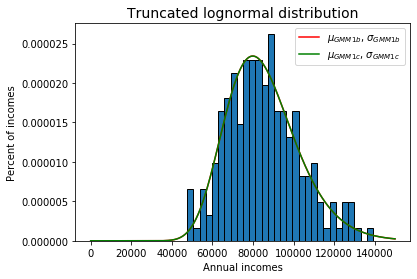

In [13]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_b, scale=np.exp(mu_GMM_1_b)),
        label='$\mu_{GMM1b}$, $\sigma_{GMM1b}$', color='r')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_c, scale=np.exp(mu_GMM_1_c)),
        label='$\mu_{GMM1c}$, $\sigma_{GMM1c}$', color='g')
ax.set_title('Truncated lognormal distribution', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

### (d)

In [14]:
mu_test_1, sig_test_1 = np.array([11, 0.5])
log_lik_h0_1 = log_lik_trunc_lognorm_1(incomes_1, mu_test_1, sig_test_1, 0, 150000)
print('The log likelihood given hypothesis value is', log_lik_h0_1)
log_lik_MLE_1 = log_lik_trunc_lognorm_1(incomes_1, mu_MLE_1, sig_MLE_1, 0, 150000)
print('The log likelihood given MLE is', log_lik_MLE_1)
LR_val_1 = 2 * (log_lik_MLE_1 - log_lik_h0_1)
print('Likelihood ratio value is', LR_val_1)
pval_h0_1 = 1.0 - sts.chi2.cdf(LR_val_1, 2)
print('Chi squared of H0 with 2 degrees of freedom p-value is', pval_h0_1)

NameError: name 'log_lik_trunc_lognorm_1' is not defined

Given that p-value is 0, we can reject $H_{0}$ at almost any level of significance. As a result, it is unlikely that the incomes are drawn from the truncated lognormal distribution with $\mu = 11$, $\sigma = 0.5$, and $0 \leq x \leq 150000$.

### (e)

In [ ]:
# Probability of earning more than 100000
Prob1 = (1 - sts.lognorm.cdf(100000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)) / 
         sts.lognorm.cdf(150000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)))
# Probability of earning less than 75000
Prob2 = (sts.lognorm.cdf(75000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)) / 
         sts.lognorm.cdf(150000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)))
print('The probability of earning more than $100,000 is {:.2f}%.'.format(100 * Prob1))
print('The probability of earning less than $75,000 is {:.2f}%.'.format(100 * Prob2))

## 2. Linear regression and MLE (4 points)

### (a)

In [ ]:
# Import data
df_2 = pd.read_csv('data/sick.txt').astype('float64')
df_2.head()

In [ ]:
# Define log likelihood function for normal distribution
def log_lik_norm_2(sick, age, children, temp_winter, beta0, beta1, beta2, beta3, sigma):
    
    epsilon = sick - beta0 - beta1 * age - beta2 * children - beta3 * temp_winter
    pdf_vals = sts.norm.pdf(epsilon, scale=sigma)
    # To avoid "divide by zero encountered in log" warning when optimizing, I replace those 0 pdfs with a small positive number
    pdf_vals[pdf_vals == 0] = 1e-10
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [ ]:
# Define the criterion function
def crit_2(params, *args):
    
    beta0, beta1, beta2, beta3, sigma = params
    sick, age, children, temp_winter = args
    log_lik_val = log_lik_norm_2(sick, age, children, temp_winter, beta0, beta1, beta2, beta3, abs(sigma))
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [ ]:
# minimize the negative sum of the log likelihood
beta0_init_2 = 0.25
beta1_init_2 = 0.01
beta2_init_2 = 0.4
beta3_init_2 = -0.01
sig_init_2 = 0.5
params_init_2 = np.array([beta0_init_2, beta1_init_2, beta2_init_2, beta3_init_2, sig_init_2])
MLE_args_2 = (df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'])
results_uncstr_2 = opt.minimize(crit_2, params_init_2, args=(MLE_args_2), method='L-BFGS-B')
beta0_MLE_2, beta1_MLE_2, beta2_MLE_2, beta3_MLE_2, sig_MLE_2 = results_uncstr_2.x
log_lik_val_MLE_2 = -results_uncstr_2.fun
vcv_MLE_2 = results_uncstr_2.hess_inv.todense()
print('The MLE of beta0 is', beta0_MLE_2)
print('The MLE of beta1 is', beta1_MLE_2)
print('The MLE of beta2 is', beta2_MLE_2)
print('The MLE of beta3 is', beta3_MLE_2)
print('The MLE of sigma is', abs(sig_MLE_2))
print('The log likelihood given MLE is', log_lik_val_MLE_2)
print('The variance-covariance matrix of the maximum likelihood estimation is\n', vcv_MLE_2)

### (b)

In [ ]:
beta0_test_2, beta1_test_2, beta2_test_2, beta3_test_2, sig_test_2 = np.array([1.0, 0, 0, 0, 0.1])
log_lik_h0_2 = log_lik_norm_2(df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'], 
                              beta0_test_2, beta1_test_2, beta2_test_2, beta3_test_2, sig_test_2)
print('The log likelihood given hypothesis value is', log_lik_h0_2)
log_lik_MLE_2 = log_lik_norm_2(df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'], 
                               beta0_MLE_2, beta1_MLE_2, beta2_MLE_2, beta3_MLE_2, abs(sig_MLE_2))
print('The log likelihood given MLE is', log_lik_MLE_2)
LR_val_2 = 2 * (log_lik_MLE_2 - log_lik_h0_2)
print('Likelihood ratio value is', LR_val_2)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val_2, 5)
print('Chi squared of H0 with 5 degrees of freedom p-value is', pval_h0)

Given that p-value is 0, we can reject $H_{0}$ at almost any level of significance. As a result, it is unlikely that age, number of children, and average winter temperature have no effect on the number of sick days. In other words, the likelihood is zero.